In [72]:
import os
import pickle

import numpy as np
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from yellowbrick.classifier import ConfusionMatrix, ROCAUC

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Load in the Model

In [2]:
with open("../models/rf_classifier_v1.pkl", "rb") as file:
    rf_model = pickle.load(file)

# Load in full data

In [5]:
csvs = []

for root, dirs, files in os.walk("../data/user_labeled/labeled_formatted/"):
    csvs += files
    
csvs

['Digital recording.csv',
 'Starcraft.csv',
 'Evidence-based policy.csv',
 'Exercise_physiology.csv',
 'Prevention science.csv',
 'Mental health.csv',
 '[SKIP]Stargate.csv',
 'Counterpoint.csv',
 'Atmospheric science.csv',
 'Stargate.csv',
 'Decision tree.csv',
 'Sonata form.csv']

In [10]:
dfs = []

for filename in csvs:
    if "SKIP" in filename:
        continue
    labeled = filename
    unlabeled = filename.replace(" ", "_").replace(".csv", ".zip")
    
    # get labeled and unlabeled date for merge
    labeled_df = pd.read_csv(f"../data/user_labeled/labeled_formatted//{labeled}")
    unlabeled_df = pd.read_csv(f"../data/user_labeled/unlabeled/{unlabeled}")
    
    # rename columns in labeled to match those in unlabeled. 
    labeled_df.rename(columns={"Topic": "node", "Before/After": "label"}, inplace=True)
    
    
    merged = labeled_df.merge(unlabeled_df, on="node", how="left")
    
    dfs.append(merged)

    
# combine dfs
total_labeled = dfs[0]
for i in range(1, len(dfs)):
    df = dfs[i]
    total_labeled = pd.concat([total_labeled, df])

total_labeled.label.value_counts()

after     234
before    145
Name: label, dtype: int64

In [13]:
total_labeled

,node,label,degree,category_matches_with_source,in_edges,out_edges,shared_neighbors_with_entry_score,centrality,page_rank,adjusted_reciprocity,shortest_path_length_from_entry,shortest_path_length_to_entry,jaccard_similarity,primary_link,similarity_rank
0,Digital recording,NaN,0.041407,0.5,0.019035,0.237477,1.000000,0.386991,0.049862,0.093777,0.000000,0.00,1.000000,0.0,1.000000
1,Sound-on-film,after,0.025108,1.0,0.014894,0.110699,0.213642,0.288900,0.042975,0.054338,0.166667,0.20,0.131959,0.0,0.499921
2,DA-88,NaN,0.012943,0.5,0.004079,0.093383,0.269815,0.350101,0.010730,0.042945,0.166667,0.20,0.194888,0.0,0.342064
3,High fidelity,before,0.032059,1.0,0.023052,0.100804,0.118135,0.290131,0.052974,0.036810,0.166667,0.40,0.131229,0.0,0.332476
4,Loudspeaker,before,0.010666,0.0,0.005624,0.054422,0.208191,0.150838,0.017363,0.049080,0.166667,0.20,0.216463,1.0,0.326242
5,ADAT,after,0.017857,0.5,0.007911,0.105751,0.266462,0.423408,0.020317,0.049956,0.166667,0.20,0.191257,0.0,0.325117
6,Hard disk recorder,NaN,0.016719,0.5,0.006983,0.103278,0.216418,0.132719,0.013911,0.043821,0.166667,0.20,0.206304,0.0,0.302718
7,Variable Control Voice Actuator,NaN,0.000300,1.0,0.000062,0.003092,0.003396,0.000153,0.000257,0.000000,0.500000,0.20,0.000000,0.0,0.302501
8,Comparison of analog and digital recording,NaN,0.017318,0.5,0.005129,0.128015,0.216814,0.163493,0.013442,0.043821,0.166667,0.20,0.210526,0.0,0.302118
9,Alesis,after,0.006472,0.5,0.004450,0.022882,0.025641,0.039679,0.008860,0.012270,0.166667,0.20,0.018767,0.0,0.285553


# Extract features and targets

In [73]:
# Unlabeled data (to be labeled by current working model)
unlabeled = total_labeled[~total_labeled.label.notnull()]
X_unlabeled = unlabeled.drop(["node", "label", "similarity_rank"], axis=1).dropna()


# Test data (Our user labeled data)
user_labeled = total_labeled.dropna()

X_test = user_labeled.drop(["node", "label", "similarity_rank"], axis=1)
y_test = user_labeled.label

# Make Predictions on X_unlabeled & See to Class Imbalance

In [74]:
y_preds = rf_model.predict(X_unlabeled)

In [77]:
X_train = X_unlabeled
y_train = y_preds

cols = X_train.columns

ros = RandomOverSampler()

# class imbalance oversampling 
X_train, y_train = ros.fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
y_train = pd.Series(y_train)

y_train.value_counts()

before    466
after     466
dtype: int64

# Train new model on semi-supervised labeled

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   16.5s finished
/home/qdizon/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Params:	 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 8, 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 100} 


              precision    recall  f1-score   support

       after       0.80      0.72      0.76       231
      before       0.61      0.71      0.66       144

    accuracy                           0.71       375
   macro avg       0.70      0.71      0.71       375
weighted avg       0.73      0.71      0.72       375

Train Score:	 0.9109442060085837
Test Score:	 0.7146666666666667


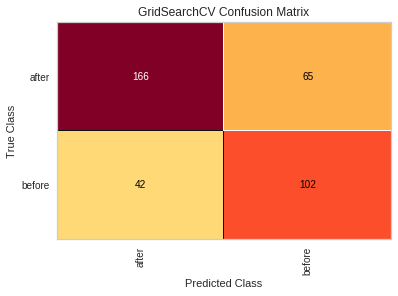

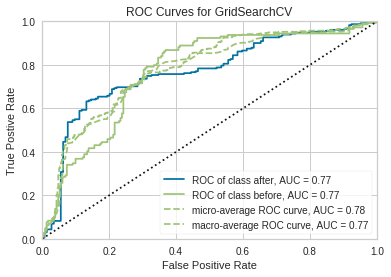

In [78]:
rf2 = RandomForestClassifier(n_jobs=-1)

params = {
#     "pca__n_components": [4,5,6,7,8,9],
    "criterion": ["gini", "entropy"], # entropy
    "n_estimators": [100, 500, 1000], # 100
    "max_depth": [5, 10], # 10
    "min_samples_split": [5], # 5
    "min_samples_leaf": [20], # 10
    "max_leaf_nodes": [5, 8, 10], # 8
    "bootstrap": [True]  
}

rf2_model = GridSearchCV(rf2, params, cv=3, verbose=1, n_jobs=-1)

rf2_model.fit(X_train, y_train)

y_labeled_preds = rf2_model.predict(X_test)

rf2_model.score(X_test, y_test)

cm = ConfusionMatrix(rf2_model, classes=rf2_model.classes_, is_fitted=True)
visualizer = ROCAUC(rf2_model, classes=rf2_model.classes_, is_fitted=True)

print("Best Params:\t", rf2_model.best_params_, "\n\n")
print(classification_report(y_test, y_labeled_preds, target_names=rf2_model.classes_))
print("Train Score:\t", rf2_model.score(X_train, y_train))
print("Test Score:\t", cm.score(X_test, y_test))
cm.poof()

visualizer.score(X_test, y_test)
visualizer.poof()